# Fit a Step – Exercise 7

Based on the `Intrinsic Dispersion` fitting `class` you created last week create a new `class` that allow to **fit a step**.

Let's imagine a physical process having a transition at a given threshold value. This could for instance be applied to astrophysics. Cepheids (pulsating stars) have an average magnitude (luminosity in log-scale) `m0` if their pulsating period is lower than, say, `10` and an average magnitude `m1` otherwise (nb: this is not true in real life). Each group has a natural dispersion of `sigma0` and `sigma1`, respectively.

### Goal

The pulsation and magnitude of each stars have been measured (see data) and we want to derive the average magnitudes (`m0`, `m1`) and natural dispersions (`sigma0`, `sigma1`) for the Cepheids.

### Data

The data are recorded in `data/Cepheid_StepFit.dat`

### About the data and the probability for a star to be in the low- and high-frequency pulsation group

The data have errors both on the pulsation and manitude measurements. **All errors are gaussian errors** 
Because of the errors on the pulsation measurements, a given star will have a probability `p0` to belong to the low-pulsation group (below `10`) and a probability `p1=1-p0` to belong to the high-pulsation one.



In [1]:
# No annoying warnings
import warnings
warnings.filterwarnings('ignore')
# ==  Basic import == #
# plot within the notebook
%matplotlib inline
import numpy as np
import matplotlib.pyplot as mpl

## Tools for the fit

In [2]:
from scipy.optimize import minimize
from scipy import stats

# Step 1 - Read the data

In [3]:
import astropy.table as t

In [4]:
table = t.Table.read("data/Cepheid_StepFit.dat", format="ascii")

### Sorry for the negative errors. Bug while building the fake data

In [5]:
table

pulsation,puls_err,mag,mag_err
float64,float64,float64,float64
10.7262805618,-0.991925125071,0.362589167609,-0.167067818149
11.8456540358,-1.47441711686,0.661405446688,0.270360149602
8.29372283731,-2.00557087828,1.01597040111,0.311076660544
7.18562098049,-4.08728515154,0.155515968329,0.152934504583
11.3313794143,-1.43827079937,0.345182442314,0.0397369379362
9.20457104163,-1.06753922942,-0.104938570016,-0.138390245452
11.6401924192,-1.43743358886,0.443437776548,0.16803211009
12.4981457903,0.166576191529,-0.00818498809317,-0.167897235595
10.5382340905,0.0773054062061,0.716757990713,0.469007655091


# Step 2 - Build the Fitting class

In [6]:
class StepFit( object ):
    """ Class to fit a bimodal guassian distribution """
    
    FREEPARAMETERS = ["mean_a", "mean_b", "sigma_a", "sigma_b"]
    
    def __init__(self, x, y, xerr, yerr, xcut=None):
        """ Initialize the instance
        Parameter:
        ----------
        x,y,dx,dy: [N-length array]
            x and y-axis data with their respective errors.
        Return
        ------
        Void
        """
        if len(x) != len(xerr) or len(y) != len(yerr) or len(x) != len(y):
            raise ValueError("x, y , xerr and yerr must have the same size.")
        
        self.x     = np.asarray(x)
        self.xerr  = np.abs(np.asarray(xerr))
        self.y     = np.asarray(y)
        self.yerr  = np.abs(np.asarray(yerr))
        if xcut is not None:
            self.set_proba(xcut)
        
    # ---------------- #
    #  Main Methods    #
    # ---------------- #
    def fit(self, guesses, verbose=True):
        """ """
        # - Setup
        self.set_guesses(guesses)
        # - Fit
        self.fitout = minimize(self.minus_loglikelihood, self.guesses)
        if verbose:
            print self.fitout
        
    def minus_loglikelihood(self, parameters):
        """ The - sum (log(Likelihood)) for the given parameters
        This method can be used for fitting procedure
        
        Parameters
        ----------
        parameters: [N-length array]
            Values setting the model. N must be the size of mode's
            freeparameters (see self.FREEPARAMETERS)
            
        Return
        ------
        float
        """
        # - Test if the probability has been initialized
        if "proba_a" not in dir(self):
            raise AttributeError(" The probility of each object to be from 'a' or 'b' has not been set.")
            
        mean_a,mean_b, sigma_a, sigma_b = parameters
        
        Likelihood = self.proba_a * stats.norm.pdf(self.y, 
                                                   loc=mean_a, scale= np.sqrt(sigma_a**2 + self.yerr**2)) +\
                 (1-self.proba_a) * stats.norm.pdf(self.y, 
                                                   loc=mean_b, scale= np.sqrt(sigma_b**2 + self.yerr**2))
            
        return -np.sum(np.log(Likelihood))

    # --------- #
    #  SETTER   #
    # --------- #
    def set_proba(self, xcut):
        """ define the probability of each points
        to be above or below the xcut given x and xerr.
        
        Parameters
        ----------
        xcut: [float]
            Value defining the location of the step.
            
        Return
        ------
        Void
        """
        if type(xcut) is not float:
            raise TypeError("xcut must be a float.")
        
        self.xcut = xcut
        self.proba_a = stats.norm.cdf(xcut, loc=self.x, scale=self.xerr)
        
    def set_guesses(self, guesses):
        """ set the initial fit parameters 
        
        Parameters
        ----------
        guesses: [N-length array]
            the Initial values for the fit procedure. 
            N must be the number of free parameters.
            (see self.FREEPARAMETERS)
            
        Return
        ------
        Void
        """
        if len(guesses) != len(self.FREEPARAMETERS):
            raise ValueError("guess must have %d entries (%d given)"%(len(self.FREEPARAMETERS), len(guesses)))
        self.guesses = np.asarray(guesses)
        
    
    # --------- #
    #  PLOTTER  #
    # --------- #
    def plot(self, xbins=10, ybins=10):
        """ plot the data and the associated best fit (if any) """
        has_proba = "proba_a" in dir(self)
        fit_done  = "fitout" in dir(self)
        # ----------- #
        #  Axes       #
        # ----------- #
        fig = mpl.figure(figsize=[10,8])
        ax_size=0.63
        ax  = fig.add_axes([0.15,0.15,ax_size,ax_size])
        axhx = fig.add_axes([0.15,0.8,ax_size,0.18],sharex=ax)
        axhy = fig.add_axes([0.8,0.15,0.18,ax_size],sharey=ax)
        # - remove the ticks labels
        [[label.set_visible(False) for label in lticks]
            for lticks in [axhx.get_xticklabels(),axhx.get_yticklabels()]]
        [[label.set_visible(False) for label in lticks]
            for lticks in [axhy.get_xticklabels(),axhy.get_yticklabels()]]
        # ----------- #
        #  Scatter    #
        # ----------- #
        # - Scatter
        prop = dict(marker="o", s=80, linewidths = 1, cmap = mpl.cm.Blues, zorder=6)
        prop["facecolors"] = 0.5  if not has_proba else self.proba_a
        
        ax.scatter(self.x,self.y, **prop)
        ax.errorbar(self.x, self.y, xerr=self.xerr, yerr=self.yerr,
                    ecolor="0.7", zorder=0.3, marker="s",ls="None")
        # ----------- #
        #  Histo      #
        # ----------- #
        prop_hist = dict(histtype="step", lw=2,ec="k")
        if not has_proba:
            axhx.hist(self.x, xbins, **prop_hist)
            axhy.hist(self.y, ybins, 
                      orientation="horizontal",**prop_hist)
        else:
            
            # - b-group
            axhx.hist(self.x, xbins, weights = 1-self.proba_a,
                      fill=False,
                      **prop_hist)
            axhy.hist(self.y, ybins, weights = 1-self.proba_a,
                      fill=False, 
                      orientation="horizontal",
                      **prop_hist)
            # - a-group
            prop_hist["lw"] = 1
            prop_hist["ec"] = prop["cmap"](1.,0.8)
            axhx.hist(self.x, xbins, weights = self.proba_a,
                      fill=True, fc= prop["cmap"](1.,0.4),
                      **prop_hist)
            axhy.hist(self.y, ybins, weights = self.proba_a,
                      fill=True, fc= prop["cmap"](1.,0.4),
                      orientation="horizontal",
                      **prop_hist)
            
        # ------------- #
        #  Fit Results  #
        # ------------- #
        if fit_done:
            mean_a,mean_b,sigma_a, sigma_b = self.fitout["x"]
            mean_a_err,mean_b_err = np.sqrt(self.fitout["hess_inv"][0][0]),np.sqrt(self.fitout["hess_inv"][1][1])
            ax.plot([10,20], [mean_b,mean_b], scalex=False, lw=2,color="k")
            ax.plot([0,10], [mean_a,mean_a], scalex=False, lw=2,color=prop["cmap"](0.9,0.9))
            ax.fill_between([10,20], [mean_b+mean_b_err,mean_b+mean_b_err],
                            [mean_b-mean_b_err,mean_b-mean_b_err],
                            color="k", alpha=0.3)
            ax.fill_between([0,10], [mean_a+mean_a_err,mean_a+mean_a_err],
                            [mean_a-mean_a_err,mean_a-mean_a_err],
                            color=prop["cmap"](0.9,0.9), alpha=0.3)
            
            
        ax.set_ylim(-1.5,1.5)
        ax.set_xlim(0,20)

In [7]:
step = StepFit(table["pulsation"], table["mag"], table["puls_err"], table["mag_err"], xcut=10.)

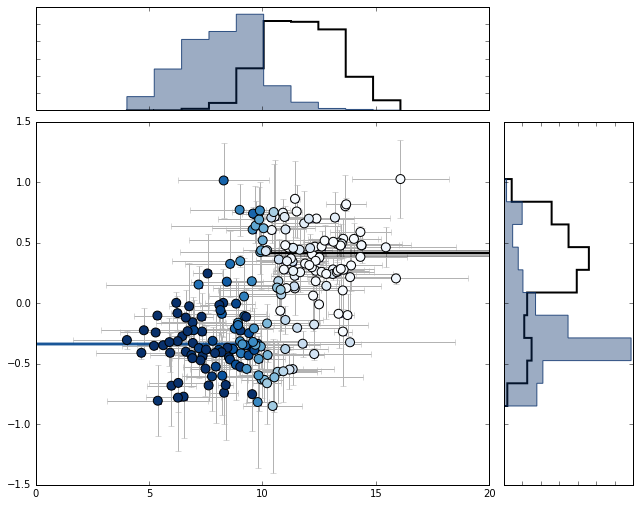

In [8]:
step.fit([-1,1,0.3,0.4], verbose=False)
step.plot()